# Mount Google Drive


In [ ]:
#Required only if using google colab

from google.colab import drive
drive.mount('/content/drive')

# Loading the initial dataset

In [1]:
#Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

# Set initial variables
DATADIR = "/Users/joe/Desktop/Temporary/Stanford Dogs Dataset/Images"
IMG_SIZE = 224


# Create a categories list
CATEGORIES = os.listdir(DATADIR)
CATEGORIES.remove(".DS_Store")

# Create a function that creates training data
def create_training_data(DATADIR, CATEGORIES, IMG_SIZE ):
    '''
    Creates a training data from the images within the folders located in DATADIR.
    CATEGORIES taken as the index of the names of the folders.
    Returns X and y as a shuffled list of the data and labels.
    NOTE: y has not been one hot encoded.
    '''
    
    X = []
    y = []
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) #This is the directory for either "Dog" or "Cat"
        class_num = CATEGORIES.index(category) #This is the index for categories
        for img in os.listdir(path): #For each image in the path
            try:
                img_array = cv2.imread(os.path.join(path,img)) #The second argument returns a grayscale image
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # Resize the image
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
    
    #Shuffle the data
    random.shuffle(training_data)
    
    #Assign to X and y
    for features, label in training_data:
        X.append(features)
        y.append(label)
    
    return X , y

#Generate images of [IMG_SIZE] pixels
X, y = create_training_data(DATADIR, CATEGORIES, IMG_SIZE)





In [ ]:
# # Check images

# image = 5
# print(CATEGORIES[y[image]])
# plt.imshow(X[image])

In [ ]:
# Export to image sets to pickle files
import pickle

path = "/Users/joe/Desktop/Temporary/Stanford Dogs Dataset/Pickle Files/"
pickle_out = open(path + "X_224.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open(path +"y_224.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

# Loading the data from the pickle file

In [ ]:
#Import relevant libraries
import pickle

#Set initial variables

path = "/Users/joe/Desktop/Temporary/Stanford Dogs Dataset/Pickle Files/"

#Load the pickle files
pickle_in = open(path + "X_224.pickle", "rb")
X = pickle.load(pickle_in)
pickle_in = open(path + "y_224.pickle", "rb")
y = pickle.load(pickle_in)





In [ ]:
#Resize the image
import cv2

IMG_SIZE = 224

X_2 = []
for image in X:
  X_2.append(cv2.resize(image, (IMG_SIZE, IMG_SIZE)))



In [ ]:
# Check that the images have loaded correctly
import matplotlib.pyplot as plt
import os

image_num = 2

DATADIR = "/Users/joe/Desktop/Temporary/Stanford Dogs Dataset/Images"
CATEGORIES = os.listdir(DATADIR)
CATEGORIES.remove(".DS_Store")

print(CATEGORIES[y[image_num]])

plt.imshow(X_2[image_num])
plt.show()

# Using Transfer Learning (Inception V3)

## Creating the model

In [ ]:
# Create a smaller subset of data

X_small = X
y_small = y

In [ ]:
# Import relevant libraries
from tensorflow.keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
from keras.applications import inception_v3
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
import matplotlib.pyplot as plt  
import math
import pickle


# Transform X and y as required
X_in = np.array(X_small)# Not sure if this is actually needed
num_classes = len(set(y_small))
# Convert y into categorical data
y_in = to_categorical(y_small, num_classes) 

# Create the train, test and validation sets
first_split = int(len(X_small) /6.) 
second_split = first_split + int(len(X_small) * 0.2)
X_test, X_val, X_train = X_in[:first_split], X_in[first_split:second_split], X_in[second_split:]
y_test, y_val, y_train = y_in[:first_split], y_in[first_split:second_split], y_in[second_split:]

# Create a function that converts arrays into tensors
def array_to_tensor(input_array):
    """
    A function to create arrays into tensors for Keras
    """
    list_of_tensors = [np.expand_dims(image, axis=0) for image in tqdm(input_array)]
    return np.vstack(list_of_tensors)

# pre-process the data for Keras - Converts to (224, 224) and converts into a numpy array using PIL.
train_tensors = array_to_tensor(X_train).astype('float32')/255
val_tensors = array_to_tensor(X_val).astype('float32')/255
test_tensors = array_to_tensor(X_test).astype('float32')/255


# Create predict files (?) Note: I'm not exactly sure what this step does exactly
input_size=224 #Note input size
num_classes=120
S=1
train_len=len(X_train)

inception_bottleneck=inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling='avg')
train_i_bf = inception_bottleneck.predict(train_tensors, batch_size=32, verbose=1)
val_i_bf = inception_bottleneck.predict(val_tensors, batch_size=32, verbose=1)
test_i_bf = inception_bottleneck.predict(test_tensors, batch_size=32, verbose=1)
# print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
# print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(val_i_bf.shape, val_i_bf.size))
# print('InceptionV3 test bottleneck features shape: {} size: {:,}'.format(test_i_bf.shape, test_i_bf.size))

# Save files (?) Not sure if this is always required
np.save('bottleneck_features_train_inception.npy', train_i_bf) 
np.save('bottleneck_features_val_inception.npy', val_i_bf) 
np.save('bottleneck_features_test_inception.npy', test_i_bf) 

# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train_inception.npy') 
val_data = np.load('bottleneck_features_val_inception.npy') 
test_data = np.load('bottleneck_features_test_inception.npy') 
batch_size=32
epochs=50

model = Sequential()  
#model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  
   
model.compile(optimizer='rmsprop',  
              loss='categorical_crossentropy', metrics=['accuracy'])  
   
history = model.fit(train_data, y_train,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(val_data, y_val))  

#Save the weights
model.save_weights('inception_model_2.h5')  

#Save the model as a pickle file
pickle.dump(model, open('model.pkl', 'wb'))
   
(eval_loss, eval_accuracy) = model.evaluate(  
     val_data, y_val, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss)) 

## Assess model performance 

In [ ]:
# Display model Graphs
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
  
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show() 

In [ ]:
# Report on performance
def report_accuracy(test_tensors, test_targets):
    """
    This creates a report showing the effecacy of the model
    """
    # get index of predicted dog breed for each image in test set
    dog_breed_predictions = [
        np.argmax(model.predict(np.expand_dims(tensor, axis=0)))
        for tensor in test_tensors
    ]

    # Find out the Number of Samples
    num_test_samples = len(dog_breed_predictions)

    print("The Number of Test images are: {}".format(num_test_samples))

    # report test accuracy
    test_accuracy = 100 * np.sum(
        np.array(dog_breed_predictions) == np.argmax(
            test_targets, axis=1)) / len(dog_breed_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)


#Load the model
model.load_weights('inception_model_2.h5')

# Display the report
print('For training set:')
report_accuracy(train_data, y_train)

print('For validation set:')
report_accuracy(val_data, y_val)

print('For test set:')
report_accuracy(test_data, y_test)

## Test a single image

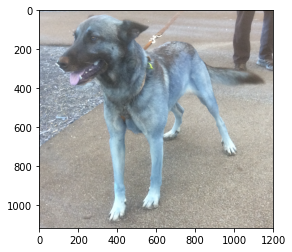

In [2]:
# #Define the image
import cv2
import matplotlib.pyplot as plt
image_path = "/Users/joe/Desktop/Screen Shot 2022-02-23 at 8.26.00 am.png"
single_test = cv2.imread(image_path)
plt.imshow(single_test)

In [3]:
# Load the ML  Model
import pickle
model = pickle.load(open('model.pkl', 'rb'))


2022-02-23 08:26:55.451603: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#Note: For some reason, the image needs to be convereted into a list first

#Import relevant libraries
import os
import numpy as np
from tqdm import tqdm
from keras.applications import inception_v3

# Convert into a list
_single_test = [single_test]

# Resize the image

IMG_SIZE = 224
temp_list = []
for image in _single_test:
    temp_list.append(cv2.resize(image, (IMG_SIZE, IMG_SIZE)))
_single_test = temp_list

# Convert to an array
_single_test = np.array(_single_test)


#Convert image into tensor
def array_to_tensor(input_array):
    list_of_tensors = [
        np.expand_dims(image, axis=0) for image in tqdm(input_array)
    ]
    return np.vstack(list_of_tensors)


_single_test = array_to_tensor(_single_test).astype('float32') / 255

#Do this bottle neck thing
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet',
                                                include_top=False,
                                                pooling='avg')
_single_test = inception_bottleneck.predict(_single_test,
                                            batch_size=32,
                                            verbose=1)

#Perform prediction
dog_breed_predictions = [
    np.argmax(model.predict(np.expand_dims(tensor, axis=0)))
    for tensor in _single_test
]
dog_breed_predictions

# Create a list of breeds
DATADIR = "/Users/joe/Desktop/Temporary/Stanford Dogs Dataset/Images"
CATEGORIES = os.listdir(DATADIR)
CATEGORIES.remove(".DS_Store")

print(CATEGORIES[dog_breed_predictions[0]])

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1396.24it/s]


1/1 [==============================] - 1s 1s/step
n02105162-malinois


# Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

datagen = ImageDataGenerator(
    featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    brightness_range = (0.5, 1.),
    zoom_range = (0.3, 1.5))

testgen = ImageDataGenerator( rescale = 1./1.)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

model_data_aug = build_model()

train_flow = datagen.flow(X_train, y_train, batch_size=16)
# We shouldnt augment the validation set
val_flow = testgen.flow(X_val, y_val, batch_size=16)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)



In [ ]:
history_data_aug = model_data_aug.fit(train_flow,
                                      validation_data = val_flow, 
                                      epochs = 100,
                                      callbacks=[es])

Data augmentation didn't necessarily give the best result as there was only a validation accuracy of 14-16.2%. Due to the early stopping criteria, the model stopped at epoch 29-48

# Other resources

https://github.com/CuitingZhong/dog_breed_identification/blob/master/Inception%20model/Inception.ipynb

https://github.com/aribiswas/stanford-dogs-classifier/blob/master/model.py

https://hljames.github.io/dog-breed-classification/Models.html
    
